In [28]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display


# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [29]:
def Plotter(acc,val_acc,loss,val_loss,l_r):
  
  plt.plot(acc, label='accuracy')
  plt.plot(val_acc, label = 'val_accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.show()


  plt.plot(loss, label='loss')
  plt.plot(val_loss, label = 'val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('loss')
  plt.legend(loc='lower right')
  plt.show()

  plt.plot(l_r, label='Learning Rate')
  # plt.plot(val_loss, label = 'val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('LR')
  plt.legend(loc='lower right')
  plt.show()

In [30]:
data_dir = pathlib.Path('data/mini_speech_commands')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

In [31]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['right' 'left' 'up' 'stop' 'yes' 'no' 'down' 'go']


In [32]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 8000
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'data/mini_speech_commands/down/8830e17f_nohash_2.wav', shape=(), dtype=string)


In [33]:
train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 800]
test_files = filenames[-800:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 6400
Validation set size 800
Test set size 800


In [34]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

In [35]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)

  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return parts[-2] 

In [36]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [37]:
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

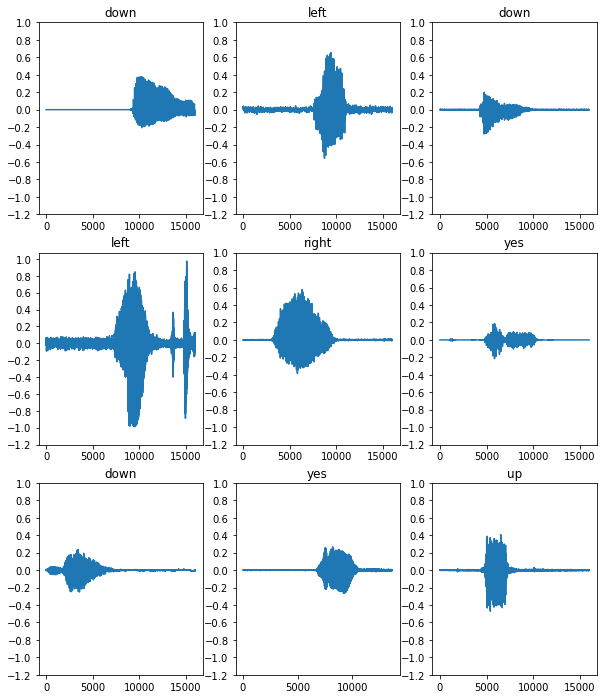

In [38]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [39]:
def get_spectrogram(waveform):
  # Padding for files with less than 16000 samples
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
      
  spectrogram = tf.abs(spectrogram)

  return spectrogram

In [40]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: down
Waveform shape: (16000,)
Spectrogram shape: (124, 129)
Audio playback


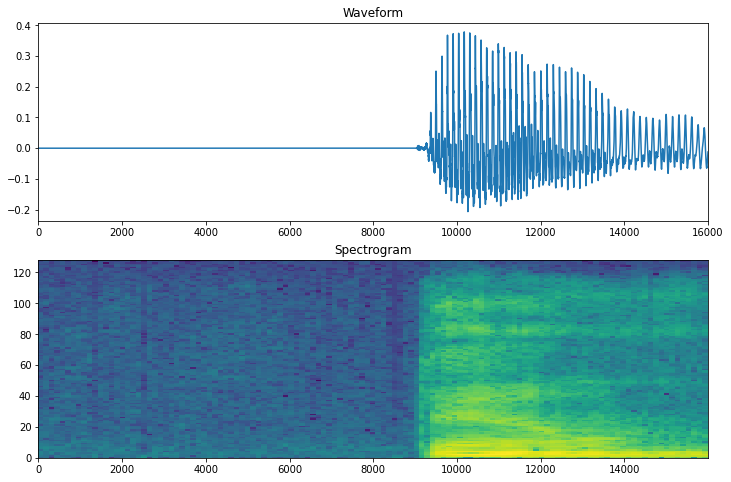

In [41]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

Now transform the waveform dataset to have spectrogram images and their corresponding labels as integer IDs.

In [42]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [43]:
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


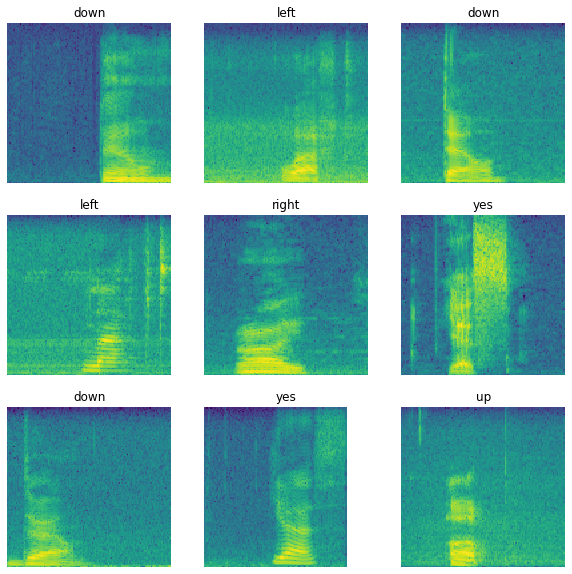

In [44]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')
  
plt.show()

In [45]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds

In [46]:

train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [47]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [48]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [49]:
def mymodel():
  for spectrogram, _ in spectrogram_ds.take(1):
    input_shape = spectrogram.shape
  print('Input shape:', input_shape)
  num_labels = len(commands)

  norm_layer = preprocessing.Normalization()
  norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

  model = models.Sequential([
      layers.Input(shape=input_shape),
      preprocessing.Resizing(32, 32), 
      norm_layer,
      layers.Conv2D(32, 3, activation='relu'),
      layers.Conv2D(64, 3, activation='relu'),
      layers.MaxPooling2D(),
      layers.Dropout(0.25),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dropout(0.5),
      layers.Dense(num_labels),
  ])

  model.summary()

  model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
  )

  return model

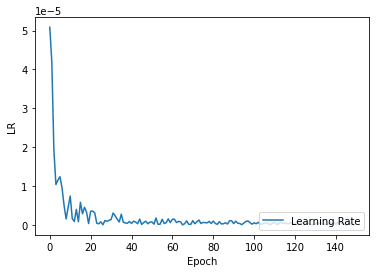

In [66]:
from random import random,randint,randrange,uniform
lr = []
epoo=150
for z,batch_size in zip(range(1,epoo+1),range(5,10000,5)):

  LR = random()/(z*10000)
  lr.append(LR)

# lr = lr[::-1] 
lord_LR = lr
# print(min(lr))


plt.plot(lr, label='Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('LR')
plt.legend(loc='lower right')
plt.show()

**Normal default fit** : LR and Batch Size default

In [51]:
EPOCHS = 150
model = mymodel()
history = model.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=EPOCHS,
)

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 32, 32, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            

In [52]:
acc_1 = history.history['accuracy']
val_acc_1 = history.history['val_accuracy']

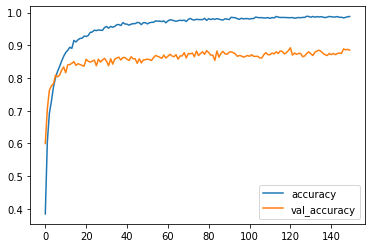

In [53]:
metrics = history.history
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

**LR ∝ BS/Epoch**

In [67]:
model = mymodel()
from random import random
from keras.callbacks import LearningRateScheduler

LR = 0.01
epoch = 1
batch_size = 100

val_acc = []
acc = []
val_loss = []
loss = []
l_r = []

num = 0

x = 0
# kr = lr
for z,batch_size in zip(range(1,epoo),range(5,10000,5)):

  # if (z%2 == 0):
  LR = random() / (z*10000)
  # lr.append(LR)

  print("\n\nepoch {z}, Learning Rate {LR}, Batch Size  {batch_size} "
                    .format(z=z,LR=LR,batch_size=batch_size))

  def set_LR(epoch,lr):
    global LR
    global l_r
    global x
    global lord_LR 

    LR=lord_LR[x]
    x+=1
    if(LR>0.009):
      LR = 0.009
    l_r.append(LR)
    return LR

  call = [ LearningRateScheduler(set_LR,verbose=1) ]

  # history = model.fit(
  #           datagen.flow(x_train, y_train), 
  #           validation_data=(x_test, y_test),
  #           epochs=epoch,
  #           batch_size=batch_size,
  #           callbacks=call
  #           )
  
  history = model.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=epoch,
    batch_size=batch_size,
    callbacks=call
  )



  acc.append(history.history['accuracy'])
  val_acc.append(history.history['val_accuracy'])
  loss.append(history.history['loss'])
  val_loss.append(history.history['val_loss'])

  # if(num >= 50 ):
  #   x = input("type anything if you want to continue >  ")
  #   num = 0
  # num += 1


Input shape: (124, 129, 1)
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_4 (Resizing)        (None, 32, 32, 1)         0         
_________________________________________________________________
normalization_4 (Normalizati (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)        

In [68]:
acc_2 = acc
val_acc_2 = val_acc

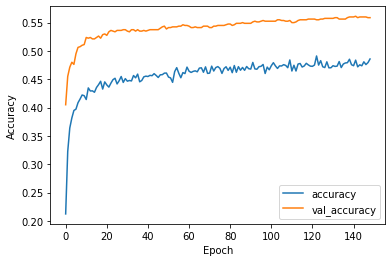

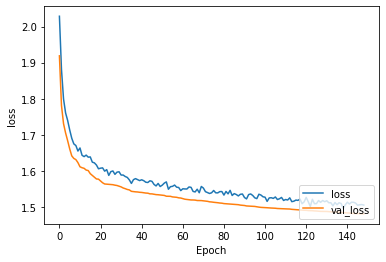

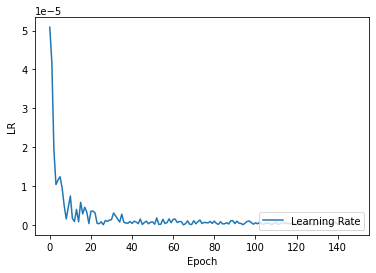

In [69]:
Plotter(acc,val_acc,loss,val_loss,l_r)

**Keeping batch size constant**

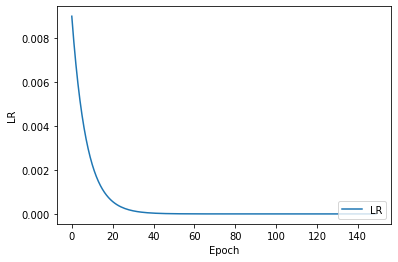

In [57]:

initial_learning_rate = 0.009
decay_steps=5
decay_rate=0.5
LR = []
for i in range(150):
  lr = initial_learning_rate * decay_rate **(i / decay_steps)
  LR.append(lr)
plt.plot(LR, label='LR')
# plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('LR')
plt.legend(loc='lower right')
plt.show()

In [70]:
from keras.callbacks import LearningRateScheduler
model = mymodel()
# epoo = 1
initial_learning_rate = 0.009
decay_steps=5
decay_rate=0.5
LR = []
def setLR(step):
  global LR
  lr = initial_learning_rate * decay_rate **(step / decay_steps)
  LR.append(lr)
  print("called here")
  return lr

call = [ LearningRateScheduler(setLR,verbose=1) ]


history = model.fit(
    train_ds, 
    validation_data=val_ds, 
    # batch_size = batch_size, 
    epochs=epoo,
    callbacks=call,
  )

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

Input shape: (124, 129, 1)
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_5 (Resizing)        (None, 32, 32, 1)         0         
_________________________________________________________________
normalization_5 (Normalizati (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)        

In [71]:
acc_3 = acc
val_acc_3 = val_acc

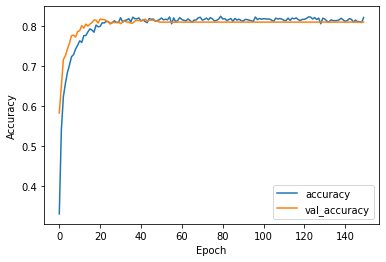

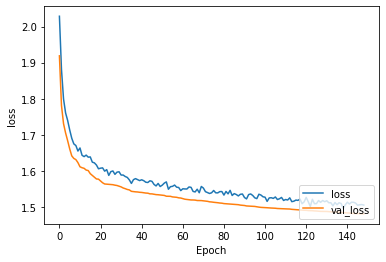

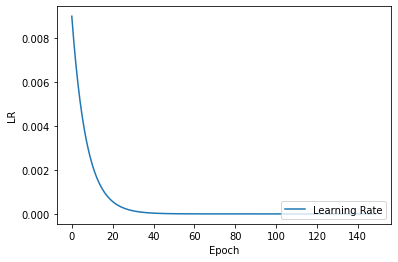

In [72]:
Plotter(acc_3,val_acc_3,loss,val_loss,LR)

**LR constant**

In [73]:
model = mymodel()

from keras.callbacks import LearningRateScheduler

LR = 0.01

epoch = 1
batch_size = 100

val_acc = []
acc = []
val_loss = []
loss = []
l_r = []
for z,batch_size in zip(range(1,epoo+1),range(5,10000,5)):

  LR = (batch_size)/(((z+1)**(3/2))*80)
  LR=LR/8

  print("\n\nepoch {z}, Learning Rate {LR}, Batch Size  {batch_size} "
                    .format(z=z,LR=LR,batch_size=batch_size))

  def set_LR(epoch,lr):
    global LR
    global l_r
    l_r.append(LR)
    return LR

  call = [ LearningRateScheduler(set_LR,verbose=1) ]

  history = model.fit(
            train_ds,
            validation_data = val_ds,
            epochs=epoch,
            batch_size=batch_size,
            # callbacks=call
            )



  acc.append(history.history['accuracy'])
  val_acc.append(history.history['val_accuracy'])
  loss.append(history.history['loss'])
  val_loss.append(history.history['val_loss'])

Input shape: (124, 129, 1)
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_6 (Resizing)        (None, 32, 32, 1)         0         
_________________________________________________________________
normalization_6 (Normalizati (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_6 (Flatten)        

In [74]:
acc_4 = acc
val_acc_4 = val_acc

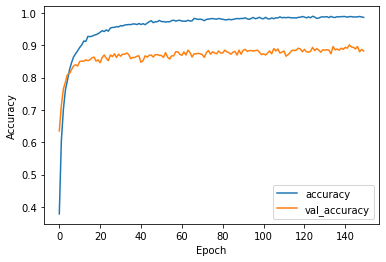

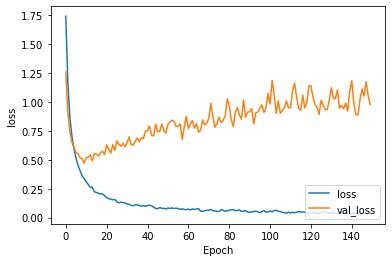

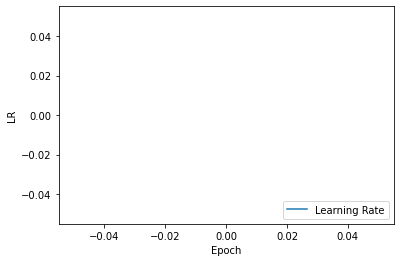

In [75]:
Plotter(acc,val_acc,loss,val_loss,l_r)

**Plotting all of them**

---



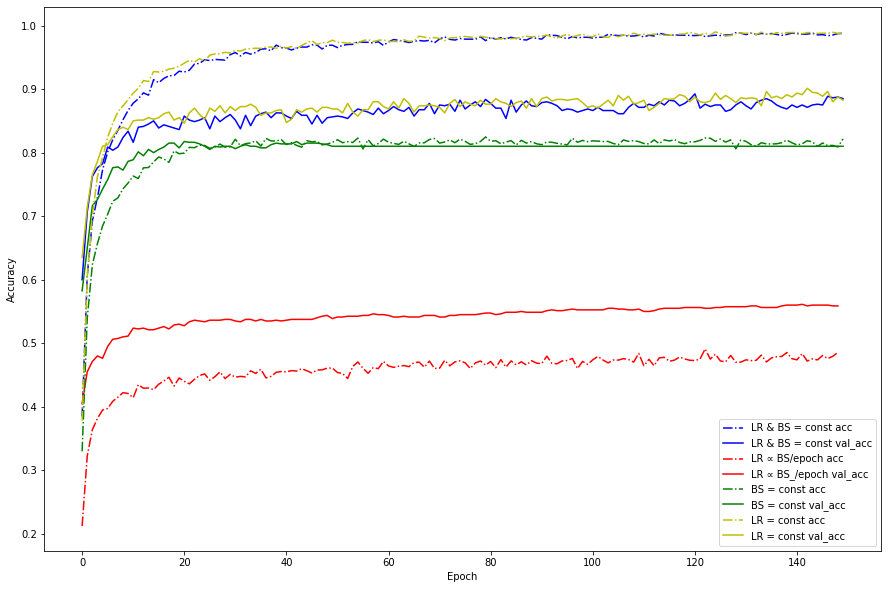

In [76]:
plt.figure(figsize=(15, 10))

plt.plot(acc_1, label='LR & BS = const acc',ls='-.',c='b')
plt.plot(val_acc_1, label = 'LR & BS = const val_acc',c='b')
plt.plot(acc_2, label='LR ∝ BS/epoch acc',ls='-.',c='r')
plt.plot(val_acc_2, label = 'LR ∝ BS_/epoch val_acc',c='r')
plt.plot(acc_3, label='BS = const acc',ls='-.',c='g')
plt.plot(val_acc_3, label = 'BS = const val_acc',c='g')
plt.plot(acc_4, label='LR = const acc',ls='-.',c='y')
plt.plot(val_acc_4, label = 'LR = const val_acc',c='y')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()


# case4_fashion_acc,case4_fashion_val_acc0